In [9]:
!pip install xgboost yfinance scikit-learn

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB 495.5 kB/s eta 0:02:26
   ---------------------------------------- 0.1/72.0 MB 656.4 kB/s eta 0:01:50
   ---------------------------------------- 0.1/72.0 MB 819.2 kB/s eta 0:01:28
   ---------------------------------------- 0.1/72.0 MB 658.7 kB/s eta 0:01:50
   ---------------------------------------- 0.2/72.0 MB 831.5 kB/s eta 0:01:27
   ---------------------------------------- 0.3/72.0 MB 927.4 kB/s eta 0:01:18
   ---------------------------------------- 0.4/72.0 MB 1.1 MB/s eta 0:01:08
   ---------------------------------------- 0.4/72.0 MB 1.1 MB/s eta 0:01:04
   ---------------------------------------- 0.5/72.0 MB 1.1 MB/s eta 0:01:04
   ---------------------------------------- 0.6/72.0 MB 1.2 MB/s eta 0:01:01
   -----

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import timedelta

# 1. VERİLERİ ÇEKİYORUZ
# --------------------------------------------------------
tickers = {
    'BTC': 'BTC-USD',
    'Gold': 'GC=F',   # Altın
    'Silver': 'SI=F', # Gümüş
    'Rates': '^TNX'   # ABD 10 Yıllık Tahvil (Fed Faiz Göstergesi)
}

print("Piyasa verileri (Altın, Gümüş, Faiz, BTC) çekiliyor...")
# Son 5 yılın verisi, piyasa dinamiklerini anlamak için idealdir
df_list = []
for name, ticker in tickers.items():
    try:
        data = yf.download(ticker, period="5y", auto_adjust=True, progress=False)
        if isinstance(data.columns, pd.MultiIndex):
            data = data.xs('Close', axis=1, level=0)
        else:
            data = data[['Close']]
        data.columns = [name]
        df_list.append(data)
    except Exception as e:
        print(f"Hata: {name} alınamadı.")

# Verileri birleştir
df = pd.concat(df_list, axis=1).ffill().dropna()

# 2. ÖZNİTELİK MÜHENDİSLİĞİ: "DEĞİŞİM" ÜZERİNE EĞİTİM
# --------------------------------------------------------
# Fiyatları değil, günlük % değişimleri kullanıyoruz.
df_pct = df.pct_change().dropna()

# Hedef: BTC'nin YARINKİ değişimi
df_pct['Target_BTC'] = df_pct['BTC'].shift(-1)

# Girdiler: Bugünün BTC, Altın, Gümüş ve Faiz değişimi
features = ['BTC', 'Gold', 'Silver', 'Rates']
data_valid = df_pct.dropna()

X = data_valid[features].values
y = data_valid['Target_BTC'].values

# Eğitim
split = int(len(X) * 0.95)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Model {len(X_train)} günlük veriyle eğitiliyor...")

# Model: İlişkileri öğrenen XGBoost
model = xgb.XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.01, 
    max_depth=5, 
    objective='reg:squarederror',
    n_jobs=-1
)
model.fit(X_train, y_train)
print("Model eğitimi tamamlandı. Piyasa korelasyonları öğrenildi.")

Piyasa verileri (Altın, Gümüş, Faiz, BTC) çekiliyor...
Model 1733 günlük veriyle eğitiliyor...
Model eğitimi tamamlandı. Piyasa korelasyonları öğrenildi.


SENARYO: Fed Faiz İndirimi Beklentisi (Kripto Dostu Ortam)


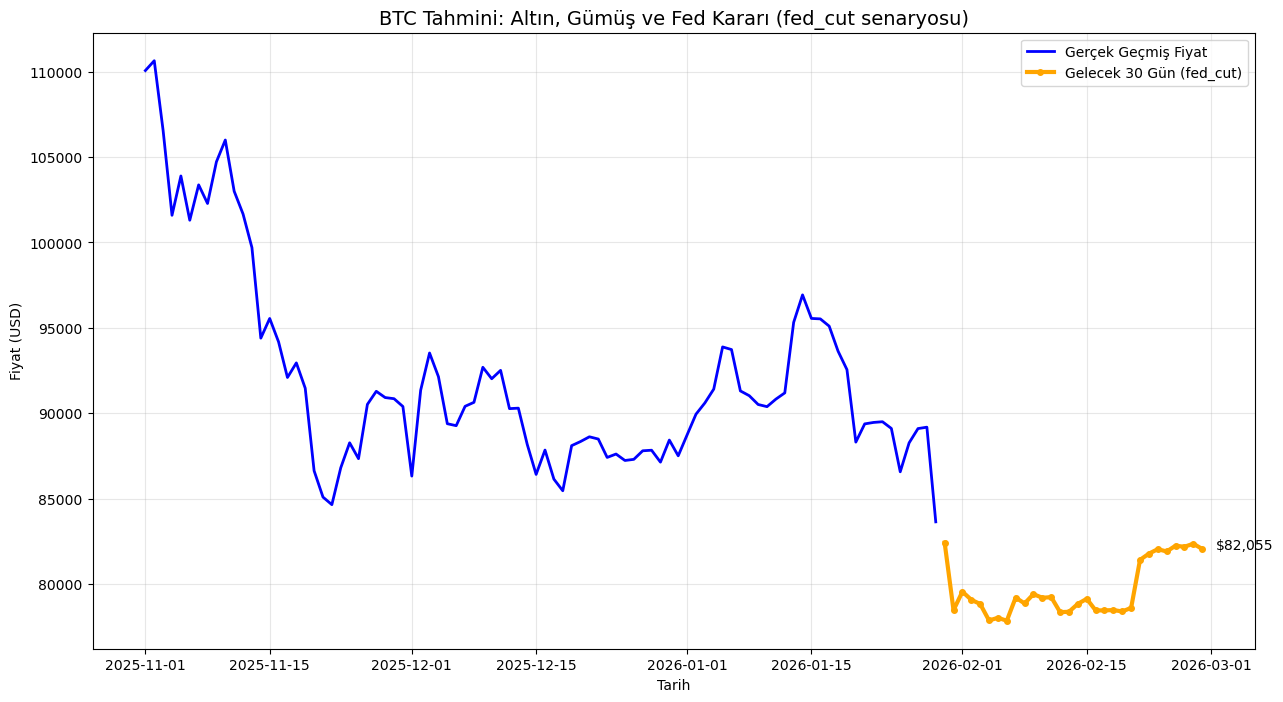


--- MODEL İÇGÖRÜLERİ ---
Model, Bitcoin'in Altın ve Faiz oranlarına olan duyarlılığını geçmiş 5 yıldan öğrendi.
Seçilen Senaryo: FED_CUT
Bu senaryoda Faizlerin (Rates) etkisi: Düşüş (Pozitif)

Tahmin Edilen İlk 5 Gün:
                  Tahmin
2026-01-30  82426.309964
2026-01-31  78472.186556
2026-02-01  79554.826611
2026-02-02  79079.097980
2026-02-03  78834.144568


In [19]:
# -----------------------------------------------------------------------------
# SENARYO YÖNETİCİSİ KISMI
# -----------------------------------------------------------------------------
# Seçenekler: "fed_cut" (Faiz İndirimi/Ralli), "fed_hike" (Sıkılaşma/Düşüş), "neutral" (Yatay)

scenario = "fed_cut"  # <-- BURAYI DEĞİŞTİREBİLİRSİN: "fed_cut", "fed_hike", "neutral"

if scenario == "fed_cut":
    # Faizler düşer, Altın ve Gümüş yükselir (Kripto için genelde POZİTİF)
    rate_trend = -0.005  # Faiz her gün %0.5 düşme eğiliminde
    gold_trend = 0.002   # Altın her gün %0.2 yükselme eğiliminde
    silver_trend = 0.003 
    print("SENARYO: Fed Faiz İndirimi Beklentisi (Kripto Dostu Ortam)")

elif scenario == "fed_hike":
    # Faizler artar, Emtialar baskılanır 
    rate_trend = 0.005   # Faiz artıyoruz
    gold_trend = -0.002  # Altın düşüyoruz
    silver_trend = -0.003
    print("SENARYO: Fed Faiz Artışı / Enflasyon Şoku (Riskli Ortam)")

else: # neutral
    rate_trend = 0.0
    gold_trend = 0.0005
    silver_trend = 0.0005
    print("SENARYO: Mevcut Piyasa Koşullarının Devamı")

# -----------------------------------------------------------------------------
# 30 GÜNLÜK SİMÜLASYON
# -----------------------------------------------------------------------------
last_prices = df.iloc[-1] # Gerçek son fiyatlar
current_btc_price = last_prices['BTC']

# Son gerçekleşen değişim oranlarını alarak başlıyoruz
last_pct = df_pct.iloc[-1][features].values 
current_inputs = last_pct.copy()

future_prices = []
future_dates = [df.index[-1] + timedelta(days=x+1) for x in range(30)]

# Rastgelelik (Noise) eklemek için (Piyasa asla dümdüz gitmez)
np.random.seed(42) 

for i in range(30):
    # 1. Model Tahmini: "Mevcut şartlara göre BTC bugün % kaç değişmeli?"
    pred_btc_change = model.predict(current_inputs.reshape(1, -1))[0]
    
    # 2. Tahmini Fiyata Çevir
    current_btc_price = current_btc_price * (1 + pred_btc_change)
    future_prices.append(current_btc_price)
    
    # 3. GELECEK GÜNÜN SENARYOSUNU HAZIRLA
    # Modelin bir sonraki gün kullanacağı girdileri simüle ediyoruz
    
    # Altın Değişimi: Trend + Biraz rastgele dalgalanma
    next_gold_change = gold_trend + np.random.normal(0, 0.005) 
    
    # Gümüş Değişimi
    next_silver_change = silver_trend + np.random.normal(0, 0.01)
    
    # Faiz Değişimi
    next_rate_change = rate_trend + np.random.normal(0, 0.01)
    
    # BTC Değişimi (Bir sonraki günün 'dünü' olacak)
    next_btc_input = pred_btc_change
    
    # Girdileri güncelle
    current_inputs = np.array([next_btc_input, next_gold_change, next_silver_change, next_rate_change])

# -----------------------------------------------------------------------------
# GÖRSELLEŞTİRME
# -----------------------------------------------------------------------------
forecast_df = pd.DataFrame(index=future_dates, data=future_prices, columns=['Tahmin'])

plt.figure(figsize=(15, 8))

# Gerçek Fiyat (Son 3 Ay)
plt.plot(df.index[-90:], df['BTC'][-90:], label='Gerçek Geçmiş Fiyat', linewidth=2, color='blue')

# Tahmin Fiyatı
plt.plot(forecast_df.index, forecast_df['Tahmin'], label=f'Gelecek 30 Gün ({scenario})', linewidth=3, color='orange', marker='o', markersize=4)

plt.title(f'BTC Tahmini: Altın, Gümüş ve Fed Kararı ({scenario} senaryosu)', fontsize=14)
plt.xlabel('Tarih')
plt.ylabel('Fiyat (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

# Son fiyatı grafiğe yaz
final_val = forecast_df['Tahmin'].iloc[-1]
plt.annotate(f"${final_val:,.0f}", (forecast_df.index[-1], final_val), xytext=(10, 0), textcoords='offset points')

plt.show()

print("\n--- MODEL İÇGÖRÜLERİ ---")
print("Model, Bitcoin'in Altın ve Faiz oranlarına olan duyarlılığını geçmiş 5 yıldan öğrendi.")
print(f"Seçilen Senaryo: {scenario.upper()}")
print(f"Bu senaryoda Faizlerin (Rates) etkisi: {'Düşüş (Pozitif)' if rate_trend < 0 else 'Yükseliş (Negatif)'}")
print("\nTahmin Edilen İlk 5 Gün:")
print(forecast_df.head())